Run in a seperate env, scratch_conda_env. I wanted to avoid installing new packages to perch_conda_env in case it breaks.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import display
from pathlib import Path
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from astral.sun import sun
from astral import LocationInfo
import pytz

In [2]:
#@title Set Paths
base_dir = os.getenv('BASE_DIR')
if not base_dir:
    raise ValueError("BASE_DIR environment variable is not set.")

In [15]:
# Select country
COUNTRY = 'maldives'

### Store raw files lists
We use this to calculate statistics, e.g get total count of days per site

In [17]:
# Folder containing audio files
audio_dir = Path("/media/mars_5tb_drive/mars_global_acoustic_study/" + COUNTRY + "_acoustics/raw_audio")

# Output CSV path
raw_file_list = os.path.join(base_dir, "marrs_acoustics/data/output_dir_" + COUNTRY + "/raw_file_list.csv")

# Check if the file already exists
if not os.path.exists(raw_file_list):
    # Collect all .wav and .WAV files
    file_list = [f for f in os.listdir(audio_dir) if f.lower().endswith('.wav')]
    
    # Save the list to a CSV file
    file_list_df = pd.DataFrame(file_list, columns=["filename"])
    file_list_df.to_csv(raw_file_list, index=False)
    
    print(f"File list created and saved to {raw_file_list}")
else:
    # Load the existing file as a DataFrame
    file_list_df = pd.read_csv(raw_file_list)
    print(f"File list loaded from {raw_file_list}")


File list loaded from /home/bwilliams/ucl_projects/marrs_acoustics/data/output_dir_maldives/raw_file_list.csv


### Calculate total recording time on each site
Note, each recorder was on a duty cycle of one in two min. So if a recorder has a total of 10 days, that means it collected 10 days of total audio across a 20 day period.

In [18]:
# Extract the 'site name' from the filename (15th and 16th characters)
file_list_df['site_name'] = file_list_df['filename'].str[4:6]

# Count the number of files (minutes of audio) per site
minutes_per_site = file_list_df['site_name'].value_counts().sort_index()

# Convert minutes to days (1440 minutes in a day)
days_per_site = minutes_per_site / 1440

# Convert to DataFrames for full display in Jupyter
minutes_per_site_df = minutes_per_site.reset_index(name="Minutes")
days_per_site_df = days_per_site.reset_index(name="Days")

# Display in list format in Jupyter
print("Minutes of audio per site:")
display(minutes_per_site_df)

print("\nDays of audio per site:")
display(days_per_site_df)


Minutes of audio per site:


,site_name,Minutes
0,D1,11785
1,D2,11802
2,H1,11882
3,H2,11882
4,N1,11174



Days of audio per site:


,site_name,Days
0,D1,8.184028
1,D2,8.195833
2,H1,8.251389
3,H2,8.251389
4,N1,7.759722


### Calculate total number of unique dates per recording

In [19]:
# Extract 'date' from the 'filename' column (characters 8 to 15)
file_list_df['date'] = file_list_df['filename'].str[7:15]

# Convert 'date' column to datetime for accurate counting
file_list_df['date'] = pd.to_datetime(file_list_df['date'], format='%Y%m%d')

# Group by 'site_name' and find unique dates
unique_dates_per_site = file_list_df.groupby('site_name')['date'].nunique()

# Subtract 1 from the number of unique dates per site
total_days_per_site = unique_dates_per_site - 1

# Convert to DataFrame for display
total_days_per_site_df = total_days_per_site.reset_index(name='Total Days')

# Display the table
print("Total number of days present in the dataset for each site:")
display(total_days_per_site_df)


Total number of days present in the dataset for each site:


,site_name,Total Days
0,D1,33
1,D2,33
2,H1,33
3,H2,33
4,N1,38


## Plot counts of individual sounds

#### Plot total count across the full period
Will plot the mean count per day of 5sec periods that contain the target sound.
As the recorders were on a duty cycle of one in two minutes, we double all counts.

In [20]:
# Set target sound and the duty cycle
TARGET_SOUND = 'scrape'
DUTY_CYCLE = 4
LOGIT_CUTOFF = 1.0

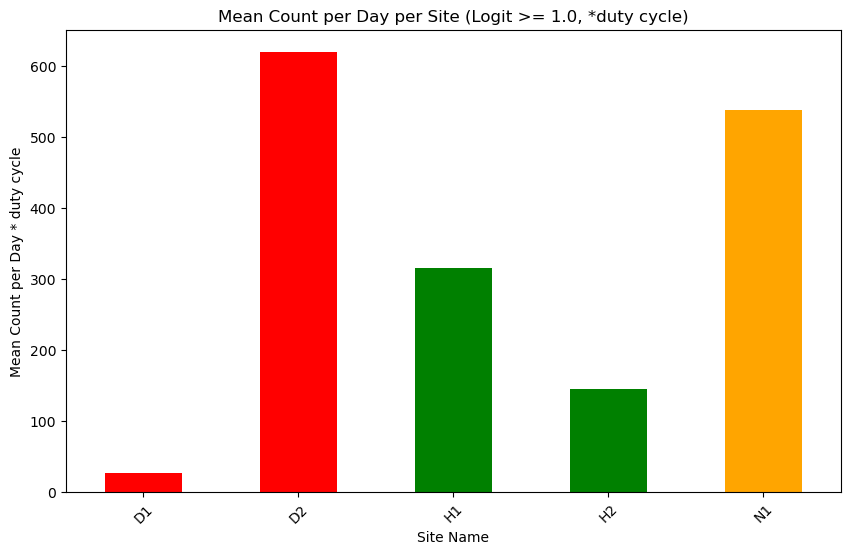

Mean Count per Day (adjusted for duty cycle):
Site D1: 27.37
Site D2: 619.83
Site H1: 315.10
Site H2: 145.43
Site N1: 538.16


In [21]:
# Load the CSV file
inference_csv = os.path.join(base_dir, f'marrs_acoustics/data/output_dir_{COUNTRY}/agile_outputs/{TARGET_SOUND}/{TARGET_SOUND}_inference.csv')
inference_df = pd.read_csv(inference_csv)

# Remove leading and trailing spaces from column names
inference_df.columns = inference_df.columns.str.strip()

# Filter rows where 'logit' is greater than or equal to the cutoff
filtered_df = inference_df[inference_df['logit'] >= LOGIT_CUTOFF]

# Extract 'filename_only' from the 'filename' column
filtered_df['filename_only'] = filtered_df['filename'].str.split('/').str[-1]

# Extract 'site_name' from 'filename_only' (positions 4 and 5)
filtered_df['site_name'] = filtered_df['filename_only'].str[4:6]

# Extract 'date_str' from 'filename_only' (positions 7 to 15)
filtered_df['date_str'] = filtered_df['filename_only'].str[7:15]

# Convert 'date_str' column to datetime
filtered_df['date'] = pd.to_datetime(filtered_df['date_str'], format='%Y%m%d')

# Count occurrences of each site and sort by site name alphabetically
site_counts = filtered_df['site_name'].value_counts().sort_index()

# Get days of audio per site (from previous code)
days_per_site = minutes_per_site / 1440

# Calculate mean count per day for each site
mean_count_per_day = site_counts / days_per_site

# Multiply the values by duty cycle for each bar to visualize a higher scale
mean_count_per_day *= DUTY_CYCLE

# Define colours based on the starting letter of each site name
colours = mean_count_per_day.index.map(lambda site: 
    'red' if site.startswith('D') else
    'green' if site.startswith('H') else
    'orange' if site.startswith('N') else
    'blue' if site.startswith('R') else 'grey'  # Default to grey if none of the specified letters match
)

# Plotting
plt.figure(figsize=(10, 6))
mean_count_per_day.plot(kind='bar', color=colours)
plt.title(f"Mean Count per Day per Site (Logit >= {LOGIT_CUTOFF}, *duty cycle)")
plt.xlabel("Site Name")
plt.ylabel("Mean Count per Day * duty cycle")
plt.xticks(rotation=45)

# Define the save path and create directories if they do not exist
save_dir = os.path.join(base_dir, 'marrs_acoustics/data/results/' + COUNTRY + '/barplots')
os.makedirs(save_dir, exist_ok=True) 

# Save the plot
save_path = os.path.join(save_dir, f"bar_plot_{TARGET_SOUND}.png")
plt.savefig(save_path)

plt.show()

# Print mean count per day for each site
print("Mean Count per Day (adjusted for duty cycle):")
for site, count in mean_count_per_day.items():
    print(f"Site {site}: {count:.2f}")


## Violin plot across sites

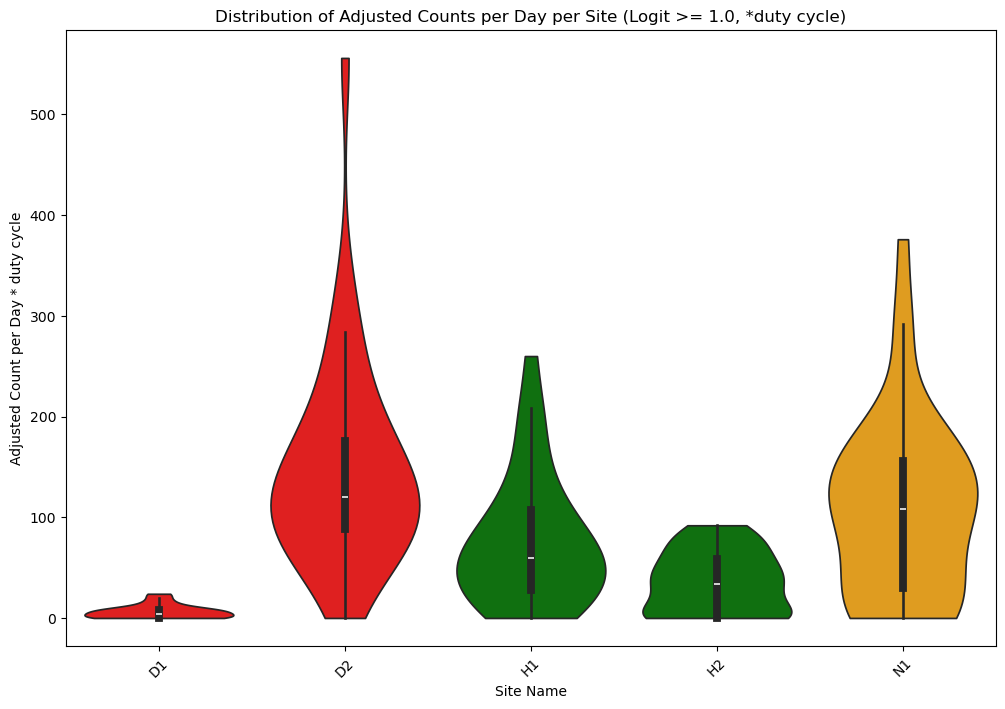

Mean Adjusted Count per Day per Site (adjusted for duty cycle):
Site D1: 6.59
Site D2: 149.41
Site H1: 76.47
Site H2: 35.29
Site N1: 107.08


In [22]:
# Group by 'site_name' and 'date', and count occurrences
counts_per_day = filtered_df.groupby(['site_name', 'date']).size().reset_index(name='count')

# Multiply 'count' by duty cycle to adjust for recording effort
counts_per_day['adjusted_count'] = counts_per_day['count'] * DUTY_CYCLE

# Now, create a DataFrame with all possible combinations of 'site_name' and 'date'

# From 'file_list_df', ensure 'filename_only', 'site_name', and 'date' are extracted
if 'filename_only' not in file_list_df.columns:
    file_list_df['filename_only'] = file_list_df['filename'].str.split('/').str[-1]
    file_list_df['site_name'] = file_list_df['filename_only'].str[4:6]
    file_list_df['date_str'] = file_list_df['filename_only'].str[7:15]
    file_list_df['date'] = pd.to_datetime(file_list_df['date_str'], format='%Y%m%d')

# Get all unique 'site_name's and 'date's
unique_sites = file_list_df['site_name'].unique()
unique_dates = file_list_df['date'].unique()

# Create a DataFrame of all combinations of 'site_name' and 'date'
all_site_dates = file_list_df[['site_name', 'date']].drop_duplicates()

# Merge 'counts_per_day' with 'all_site_dates' to include missing dates with zero counts
full_counts_per_day = pd.merge(
    all_site_dates,
    counts_per_day[['site_name', 'date', 'adjusted_count']],
    on=['site_name', 'date'],
    how='left'
)

# Fill NaN values in 'adjusted_count' with zero
full_counts_per_day['adjusted_count'] = full_counts_per_day['adjusted_count'].fillna(0)

# Define colours based on the starting letter of each site name
# (Reuse 'site_colour_mapping' if already defined)
if 'site_colour_mapping' not in locals():
    site_colour_mapping = {}
    for site in unique_sites:
        if site.startswith('D'):
            colour = 'red'
        elif site.startswith('H'):
            colour = 'green'
        elif site.startswith('N'):
            colour = 'orange'
        elif site.startswith('R'):
            colour = 'blue'
        else:
            colour = 'grey'  # Default to grey if none of the specified letters match
        site_colour_mapping[site] = colour

# Plotting
plt.figure(figsize=(12, 8))

# Create violin plot with custom color mapping and include all sites
sns.violinplot(
    x='site_name', 
    y='adjusted_count', 
    data=full_counts_per_day, 
    palette=site_colour_mapping, 
    cut=0,
    order=sorted(unique_sites)
)

plt.title(f"Distribution of Adjusted Counts per Day per Site (Logit >= {LOGIT_CUTOFF}, *duty cycle)")
plt.xlabel("Site Name")
plt.ylabel("Adjusted Count per Day * duty cycle")
plt.xticks(rotation=45)

# Define the save path and create directories if they do not exist
save_dir = os.path.join(base_dir, f'marrs_acoustics/data/results/{COUNTRY}/violinplots')
os.makedirs(save_dir, exist_ok=True) 

# Save the plot
save_path = os.path.join(save_dir, f"violin_plot_{TARGET_SOUND}.png")
plt.savefig(save_path)

plt.show()

# Calculate and print mean adjusted count per day for each site
mean_adjusted_count_per_day = full_counts_per_day.groupby('site_name')['adjusted_count'].mean()

print("Mean Adjusted Count per Day per Site (adjusted for duty cycle):")
for site, count in mean_adjusted_count_per_day.items():
    print(f"Site {site}: {count:.2f}")


## Temporal plots

#### Monthly plot
- Takes the total count of each hour, multiplies byb duty cycle.
- Grey shows nightime period. Note an artefact of the shading feature was making the nightime appear longer, so this has been trimmed back 30min either side.
- Black shows periods where the recorders were not deployed or the battery had died.
- TODO: fix unnecessary space at start and end, also tidy up a few other bits.
- TODO: Shading is not working the same between Indo and Aus. Clearly not showing night/day correctly.

In [10]:
# Set location and timezone, some moths were on local time some were on UK so take care!
# Indonesia. Moths = local time.
#latitude, longitude = -4.92913, 119.3175
#local_timezone = pytz.timezone("Asia/Makassar")

# Australia. Moths = UK time. First came on at around 2am local time.
latitude, longitude = -16.846378, 146.228253
local_timezone = pytz.timezone("Europe/London")

location = LocationInfo(latitude=latitude, longitude=longitude)


TODO: How is it deciding how many days to use? With mexico it says R1 started before all other sites, so check is it using the raw file list or just the inference outputs?

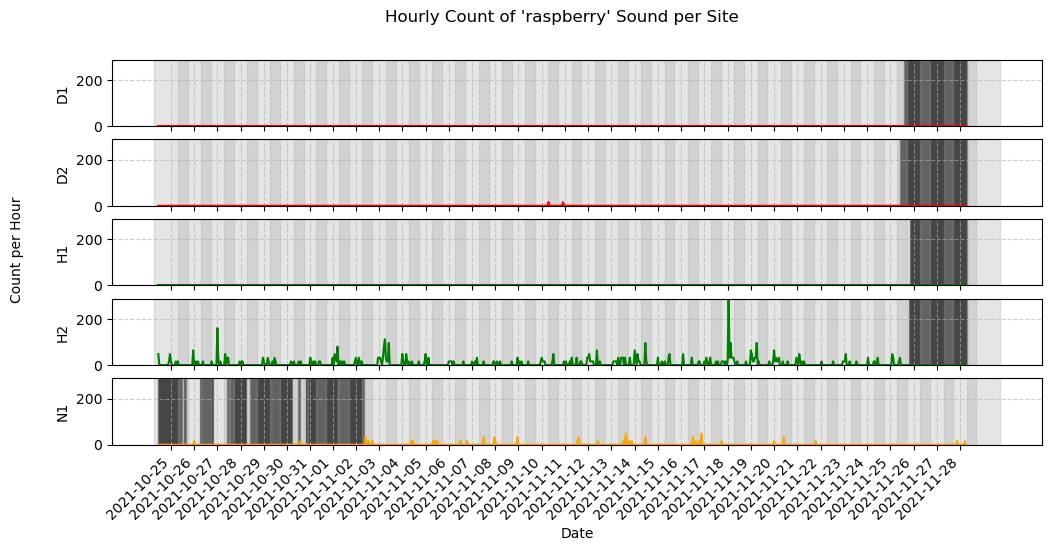

In [11]:
# Suppress warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Get unique sites from file_list_df to ensure all are included
all_sites = file_list_df['site_name'].unique()

# Extract relevant components from 'filename' and process datetime information
filtered_df['site_name'] = filtered_df['filename'].str[14:16]
filtered_df['date'] = filtered_df['filename'].str[17:25]
filtered_df['time'] = filtered_df['filename'].str[26:32]
filtered_df['datetime'] = pd.to_datetime(filtered_df['date'] + filtered_df['time'], format='%Y%m%d%H%M%S')
filtered_df['hour'] = filtered_df['datetime'].dt.floor('h')

# Aggregate sound occurrences per hour per site, adjusting for duty cycle
hourly_counts = filtered_df.groupby(['site_name', 'hour']).size().reset_index(name='count')
hourly_counts['count'] *= DUTY_CYCLE  

# Define global time range and create a complete timeline for all sites
global_start_time = filtered_df['datetime'].min().floor('h')
global_end_time = filtered_df['datetime'].max().ceil('h')
global_hours = pd.date_range(start=global_start_time, end=global_end_time, freq='h')
timeline_df = pd.DataFrame([(site, hour) for site in all_sites for hour in global_hours], columns=['site_name', 'hour'])
timeline_df = timeline_df.merge(hourly_counts, on=['site_name', 'hour'], how='left').fillna(0)

# Dictionary of recording hours for each site to identify missing hours
file_list_df['datetime'] = pd.to_datetime(file_list_df['filename'].str[7:21], format='%Y%m%d_%H%M%S')
file_list_df['hour'] = file_list_df['datetime'].dt.floor('h')
recording_hours = file_list_df.groupby('site_name')['hour'].apply(set).to_dict()

# Calculate unique local midnights based on sunset and sunrise times for consistent x-ticks
unique_dates = pd.date_range(start=global_start_time, end=global_end_time, freq='D')
local_midnights_naive = [
    (sun(location.observer, date=date, tzinfo=local_timezone)['sunset'] +
     (sun(location.observer, date=date + timedelta(days=1), tzinfo=local_timezone)['sunrise'] - 
      sun(location.observer, date=date, tzinfo=local_timezone)['sunset']) / 2).replace(tzinfo=None) 
    for date in unique_dates
]

# Plot setup
fig, axs = plt.subplots(len(all_sites), 1, figsize=(12, 1 * len(all_sites)), sharex=True)
colour_mapping = {'D': 'red', 'H': 'green', 'N': 'orange', 'R': 'blue'}
max_count = timeline_df['count'].max()*DUTY_CYCLE

for i, site in enumerate(sorted(all_sites)):
    # Filter and plot data for each site
    site_data = timeline_df[timeline_df['site_name'] == site]
    site_colour = colour_mapping.get(site[0], 'grey')
    axs[i].set_facecolor("white")
    axs[i].plot(site_data['hour'], site_data['count']*DUTY_CYCLE, color=site_colour)
    axs[i].set_ylabel(site)
    axs[i].set_ylim(0, max_count)
    axs[i].grid(True, linestyle='--', alpha=0.6)
    
    # Shade missing hours in black
    recorded_hours = recording_hours.get(site, set())
    missing_hours = [hour for hour in global_hours if hour not in recorded_hours]
    for hour in missing_hours:
        axs[i].axvspan(hour, hour + timedelta(hours=1), color='black', alpha=0.5, clip_on=True)

    # Shade night periods based on adjusted sunset and sunrise times
    for date in site_data['hour'].dt.date.unique():
        sunset = sun(location.observer, date=date, tzinfo=local_timezone)['sunset'] + timedelta(minutes=30)
        sunrise = sun(location.observer, date=date + timedelta(days=1), tzinfo=local_timezone)['sunrise'] - timedelta(minutes=30)
        sunset_naive = sunset.replace(tzinfo=None)
        sunrise_naive = sunrise.replace(tzinfo=None)
        axs[i].axvspan(sunset_naive, sunrise_naive, color='darkgrey', alpha=0.3, clip_on=True)

# Apply x-ticks at local midnights with formatted labels
plt.xticks(local_midnights_naive, [midnight.strftime('%Y-%m-%d') for midnight in local_midnights_naive], 
           rotation=45, ha='right', fontsize=10)

# Set labels and titles
plt.suptitle(f"Hourly Count of '{TARGET_SOUND}' Sound per Site")
plt.xlabel("Date")
fig.text(0.04, 0.5, 'Count per Hour', va='center', rotation='vertical')

# Define the new save path for the monthly plots and create directories if they do not exist
monthly_save_dir = os.path.join(base_dir, f'marrs_acoustics/data/results/{COUNTRY}/monthly_plots')
os.makedirs(monthly_save_dir, exist_ok=True)

# Save the plot with a month_ prefix
monthly_save_path = os.path.join(monthly_save_dir, f"month_{TARGET_SOUND}.png")
plt.savefig(monthly_save_path)

plt.show()



#### 24hr trend plot
Takes the mean count of sounds for each 24 hr period and plots these. Carefully excludes hours for where the battery was dead. TODO: Check why the midnight and 11pm bars are cut in half/overlaps the axis and make sure these are correct.


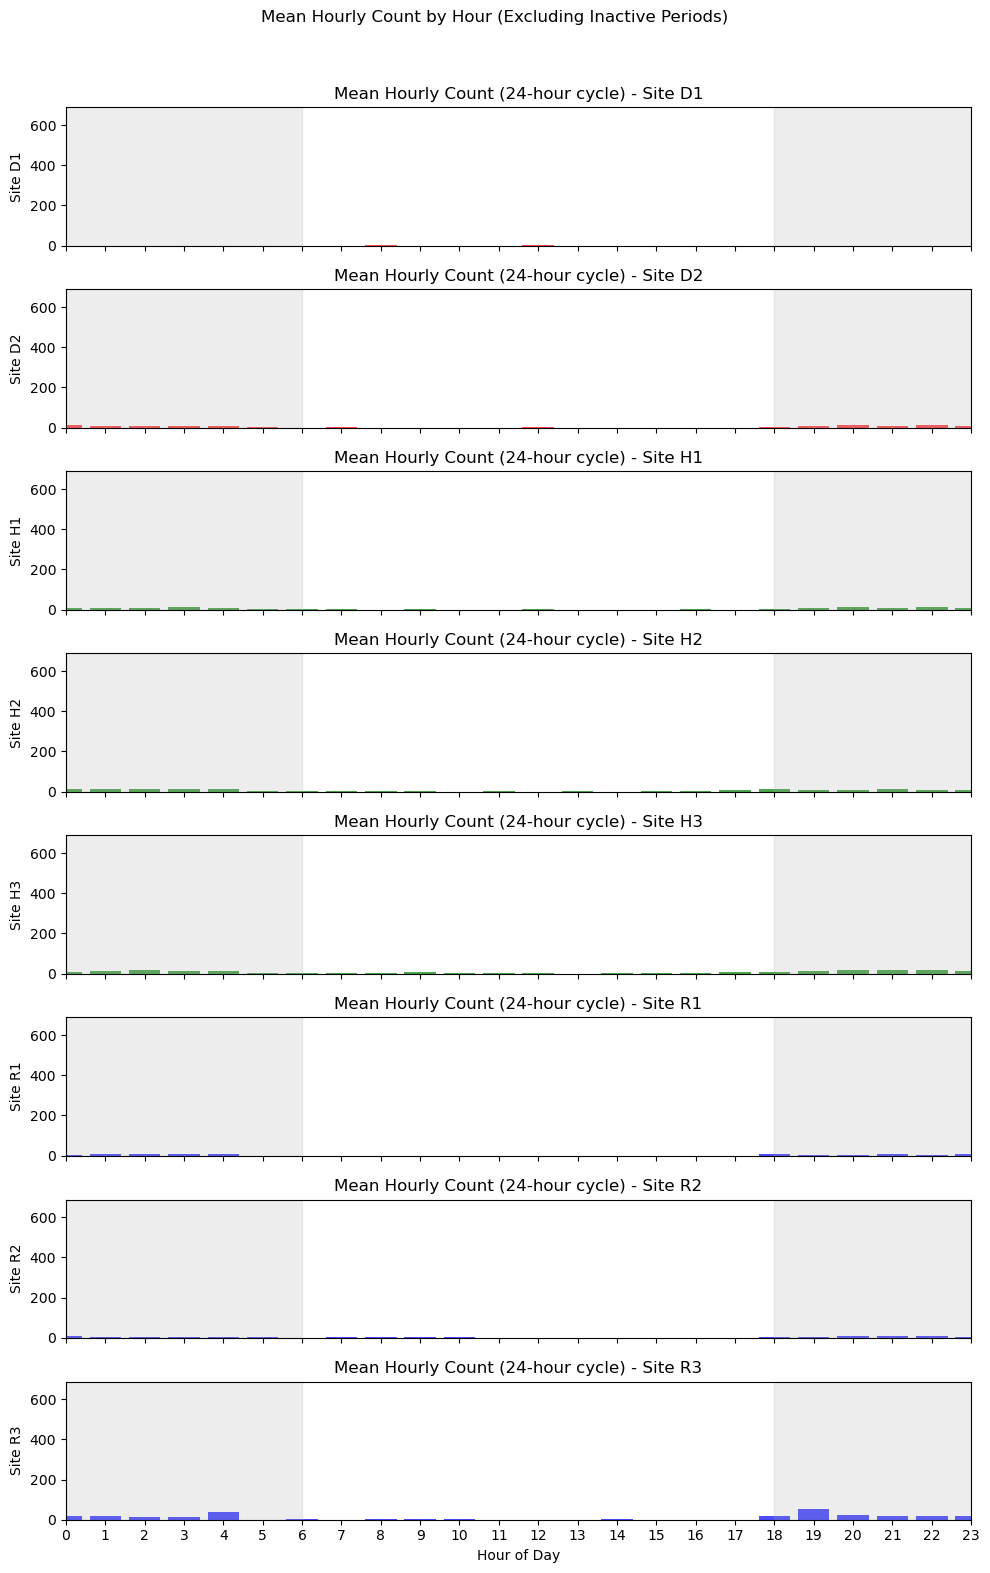

In [38]:
# Initialize a plot figure
fig, axs = plt.subplots(len(all_sites), 1, figsize=(10, 2 * len(all_sites)), sharex=True)

for i, site in enumerate(sorted(all_sites)):
    # Filter `hourly_counts` for the current site
    site_data = hourly_counts[hourly_counts['site_name'] == site].copy()
    
    # Exclude hours not in `recording_hours` for this site a.k.a when the battery was dead
    active_hours = recording_hours.get(site, set())
    site_data = site_data[site_data['hour'].isin(active_hours)]
    
    # Extract hour of the day (0-23) to calculate the mean per hour
    site_data['hour_of_day'] = site_data['hour'].dt.hour
    mean_counts = site_data.groupby('hour_of_day')['count'].mean()

    # Plot the mean count by hour
    axs[i].bar(mean_counts.index, mean_counts.values, color=colour_mapping.get(site[0], 'grey'), alpha=0.7)
    axs[i].set_xlim(0, 23)
    axs[i].set_xticks(range(0, 24, 1))  # Show every other hour for clarity
    axs[i].set_ylabel(f"Site {site}")
    axs[i].set_ylim(0, max_count)
    axs[i].set_title(f"Mean Hourly Count (24-hour cycle) - Site {site}")

    # Optionally: Add nighttime shading (assume 18:00 to 06:00 as a rough estimate for simplicity)
    axs[i].axvspan(18, 23, color='darkgrey', alpha=0.2)
    axs[i].axvspan(0, 6, color='darkgrey', alpha=0.2)

# Set shared x-axis label
plt.xlabel("Hour of Day")
plt.suptitle("Mean Hourly Count by Hour (Excluding Inactive Periods)")
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title

plt.show()


#### Rose plots of 24 hr trends
Two options:
1. Scale the axis to match the cite with the highest count (which is what you see here). Advantage: it allows comparison of sites, disadvantage: it makes many plots non readable
2. Scale axis to fit each site individually. Advantage: allows easier viewing of temporal trends, disadvantage: for some plots where there are few to no detections it still looks like it had a lot of data.
3. Could try log scale?

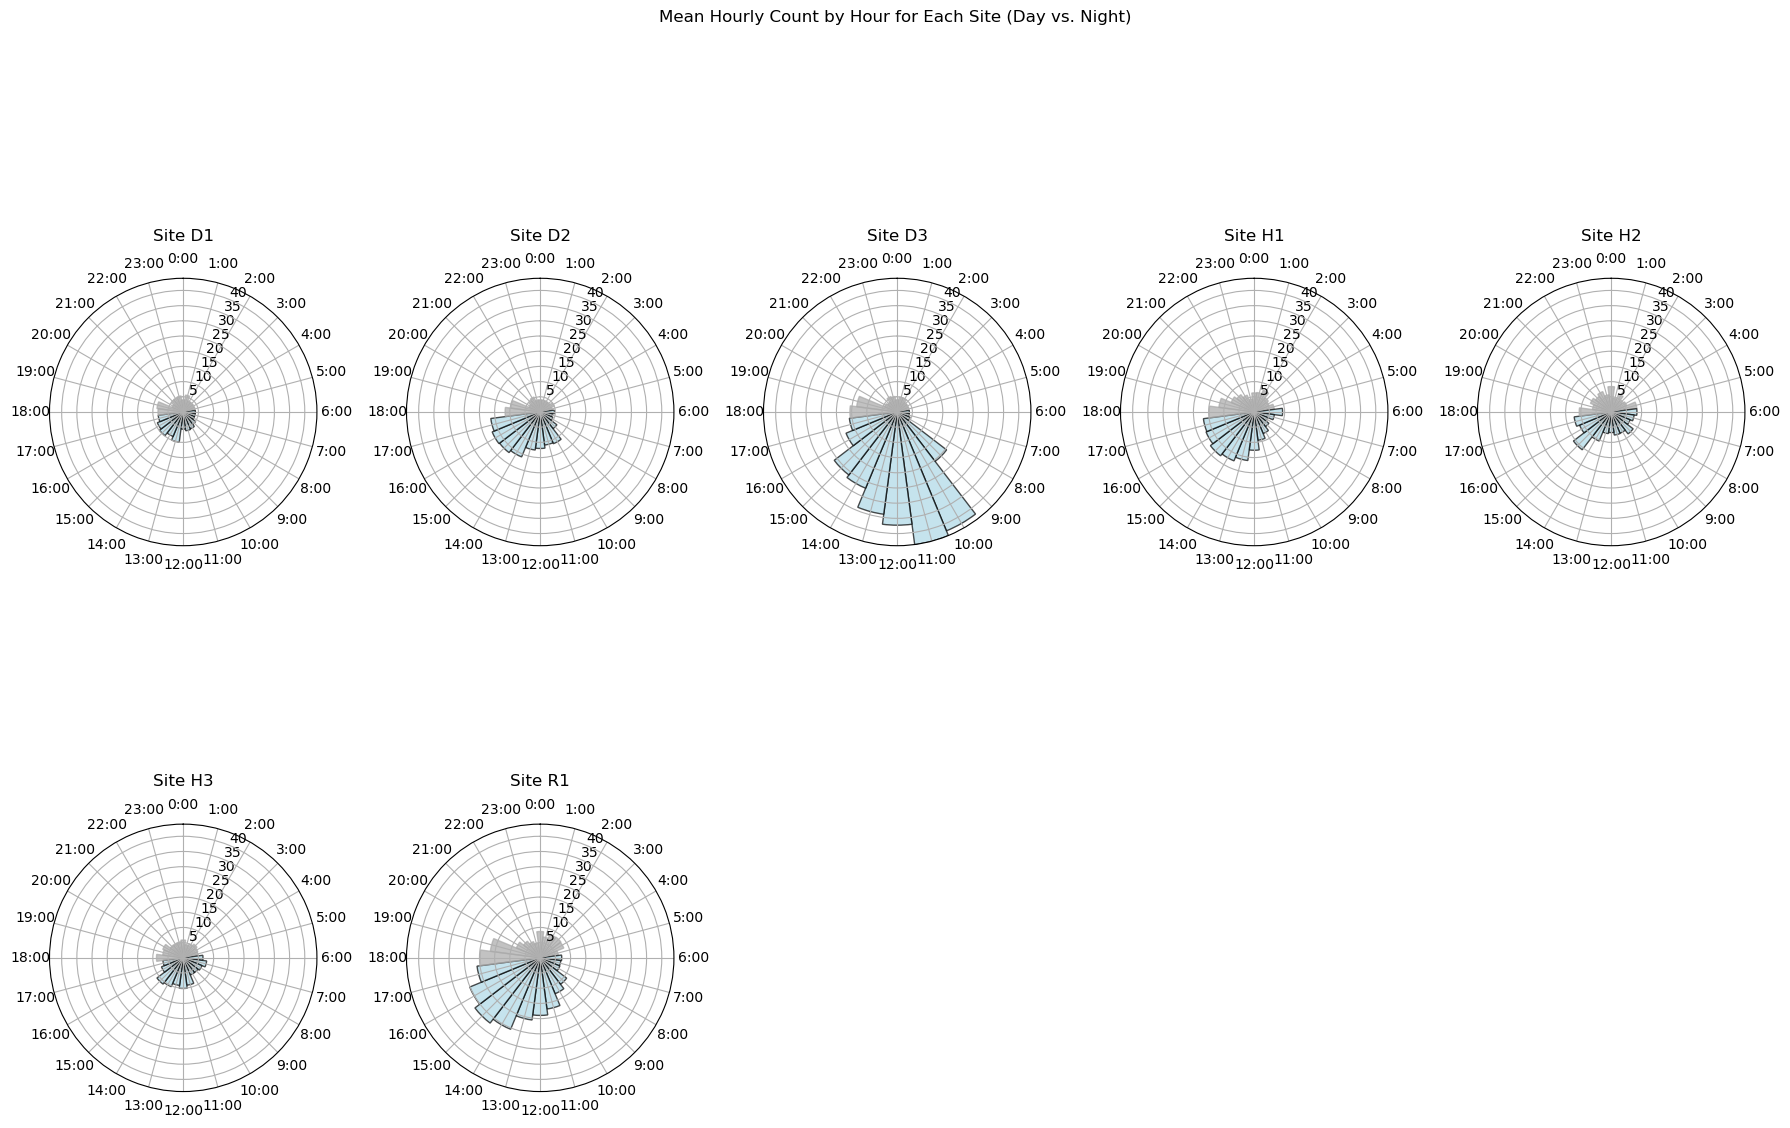

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Define hours from 0 to 23
hours = np.arange(24)
num_sites = len(all_sites)
plots_per_row = 5  # Limit to 5 plots per row

# Calculate the number of rows required
num_rows = (num_sites + plots_per_row - 1) // plots_per_row

# Determine global max count for uniform scale
global_max_count = 0

for site in all_sites:
    site_data = hourly_counts[hourly_counts['site_name'] == site].copy()
    active_hours = recording_hours.get(site, set())
    site_data = site_data[site_data['hour'].isin(active_hours)]
    site_data['hour_of_day'] = site_data['hour'].dt.hour
    mean_counts = site_data.groupby('hour_of_day')['count'].mean()
    global_max_count = max(global_max_count, mean_counts.max())

# Plot setup for a grid of polar plots
fig, axs = plt.subplots(num_rows, plots_per_row, figsize=(18, 6 * num_rows), subplot_kw={'projection': 'polar'})
axs = axs.flatten()  # Flatten for easy indexing if multiple rows

for i, site in enumerate(sorted(all_sites)):
    # Filter `hourly_counts` for the current site
    site_data = hourly_counts[hourly_counts['site_name'] == site].copy()

    # Exclude inactive hours
    active_hours = recording_hours.get(site, set())
    site_data = site_data[site_data['hour'].isin(active_hours)]

    # Calculate mean per hour (0-23)
    site_data['hour_of_day'] = site_data['hour'].dt.hour
    mean_counts = site_data.groupby('hour_of_day')['count'].mean()

    # Set up data for the polar plot
    counts = mean_counts.reindex(hours, fill_value=0).values  # Ensure all 24 hours are represented
    angles = np.radians(hours * 15)  # Convert hours to angles

    # Plot mean counts on a polar bar plot with a consistent scale
    ax = axs[i]
    bars = ax.bar(angles, counts, width=np.radians(15), color='lightblue', edgecolor='black', alpha=0.7)

    # Colour night-time hours (e.g., 18:00-06:00) as dark grey
    night_hours = list(range(18, 24)) + list(range(0, 6))
    for hour in night_hours:
        bars[hour].set_color('darkgrey')

    # Customise the plot
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_xticks(np.radians(hours * 15))
    ax.set_xticklabels([f"{h}:00" for h in hours], fontsize=10)
    ax.set_title(f"Site {site}", va='bottom')

    # Set a uniform radial limit for all plots
    ax.set_ylim(0, global_max_count)

# Remove unused subplots if there are fewer than the grid's total
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Title for the entire figure
plt.suptitle("Mean Hourly Count by Hour for Each Site (Day vs. Night)", y=1.05)
plt.tight_layout()
plt.show()
